<h1> 95% Consistency Analysis with Raw MBA Data </h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>

In [174]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [300]:
%%toggle_code
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from google.cloud import bigquery
import warnings




os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline




print('Executed')

<h3> SQL Queries

<h4> Validated dataset 2020 sql query

In [267]:
peak_download_val2020 = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        FROM
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 29
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000, .20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE)) 
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""
peak_download_val2020 = client.query(peak_download_val2020).to_dataframe()
print("executed")
print("validated dataset from Sep-Oct 2020")


executed
validated dataset from Sep-Oct 2020


<h4> Raw dataset December 2020 sql query

In [268]:
raw_download_dec2020 = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        FROM
        `broadband-data.mba_data.curr_httpgetmtDec20` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) 
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 29
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000, .20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httpgetmtDec20` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""
raw_download_dec2020 = client.query(raw_download_dec2020).to_dataframe()
print("executed")
print("raw dataset from Dec 2020")


executed
raw dataset from Dec 2020


<h4> Raw dataset April 2021 sql query


In [269]:
raw_download_apr2021 = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        FROM
        `broadband-data.mba_data.curr_httpgetmtApr21` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) 
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 29
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000, .20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (SELECT
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httpgetmtApr21` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""
raw_download_apr2021 = client.query(raw_download_apr2021).to_dataframe()
print("executed")
print("raw dataset from Dec 2020")


executed
raw dataset from Dec 2020


In [270]:
peak_download_val2020

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes,download_service_tier_1,ISP_1,tech_1,_80_80_
0,1.5,CenturyLink,DSL,1.209852,1.235936,0.662552,1.493808,1.062544,1.934584,0.022072,0.259495,65,1.5,CenturyLink,DSL,0.938294
1,3.0,CenturyLink,DSL,2.850427,2.827840,1.484872,4.765216,2.205512,5.404400,0.016840,0.898549,50,3.0,CenturyLink,DSL,2.053360
2,5.0,Cincinnati Bell,DSL,3.696203,4.214408,1.237952,4.327232,3.171976,4.814376,0.249400,1.016765,49,5.0,Cincinnati Bell,DSL,2.999680
3,6.0,Frontier,DSL,5.430807,5.683632,1.655800,7.893608,4.337272,9.551024,0.443104,1.736311,36,6.0,Frontier,DSL,1.499600
4,10.0,CenturyLink,DSL,9.118604,9.617656,6.157064,11.399624,7.968480,12.762944,0.000024,1.662674,71,10.0,CenturyLink,DSL,7.388600
5,10.0,Windstream,DSL,9.473504,9.765072,6.123840,11.489040,8.265672,14.878976,0.034528,1.999034,55,10.0,Windstream,DSL,7.939736
6,12.0,CenturyLink,DSL,12.416598,12.266384,7.917080,16.560384,10.277856,17.071624,0.031072,2.830302,65,12.0,CenturyLink,DSL,9.666347
7,12.0,Frontier,DSL,11.923940,11.446240,8.007616,16.094520,10.358320,20.093352,1.939472,2.647481,66,12.0,Frontier,DSL,9.527110
8,12.0,Windstream,DSL,12.832884,13.319752,9.577392,14.874424,12.138192,16.565360,0.520184,1.749643,51,12.0,Windstream,DSL,11.387242
9,15.0,Windstream,DSL,15.536156,16.431920,11.650992,16.577112,14.795032,21.038496,0.752656,2.029913,44,15.0,Windstream,DSL,13.461950


In [271]:
raw_download_dec2020

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes,download_service_tier_1,ISP_1,tech_1,_80_80_
0,1.5,CenturyLink,DSL,2.163081,1.306104,0.656632,1.851352,1.101640,59.770312,0.0,6.086477,52,1.5,CenturyLink,DSL,0.946632
1,3.0,CenturyLink,DSL,3.958444,2.858008,1.319512,5.200712,2.360832,100.784632,0.0,9.032919,38,3.0,CenturyLink,DSL,2.107491
2,5.0,Cincinnati Bell,DSL,5.689411,4.174176,0.000000,43.389728,2.167536,60.675280,0.0,10.047879,39,5.0,Cincinnati Bell,DSL,1.289864
3,10.0,CenturyLink,DSL,9.175047,9.687336,5.684144,11.275816,8.276648,12.636352,0.0,1.896685,60,10.0,CenturyLink,DSL,7.525350
4,10.0,Windstream,DSL,9.524690,9.984792,4.495952,13.651392,8.113704,120.181088,0.0,4.902324,43,10.0,Windstream,DSL,6.390461
5,12.0,CenturyLink,DSL,17.457847,12.363600,5.907056,17.028888,10.937720,239.843528,0.0,33.454937,55,12.0,CenturyLink,DSL,9.978384
6,12.0,Frontier,DSL,13.002231,11.479000,7.243616,16.229384,10.350552,90.309600,0.0,7.354576,51,12.0,Frontier,DSL,9.928630
7,12.0,Windstream,DSL,16.119533,13.237096,4.929088,16.560784,11.256544,183.866344,0.0,23.027121,41,12.0,Windstream,DSL,8.808608
8,15.0,Windstream,DSL,15.617526,16.481384,6.895920,21.698864,14.440880,40.974328,0.0,3.994834,36,15.0,Windstream,DSL,14.029776
9,20.0,CenturyLink,DSL,23.222379,20.079344,12.969448,25.898888,18.785392,303.256256,0.0,21.860218,46,20.0,CenturyLink,DSL,18.141429


In [272]:
raw_download_apr2021

,download_service_tier,ISP,tech,avg_Mbps,median_Mbps,low_5_pct_Mbps,top_95_pct_Mbps,low_20_pct_Mbps,max_Mbps,min_Mbps,STD,total_boxes,download_service_tier_1,ISP_1,tech_1,_80_80_
0,1.5,CenturyLink,DSL,4.657671,1.270384,0.599480,20.349328,1.103840,296.395312,0.000000,17.369741,47,1.5,CenturyLink,DSL,0.848008
1,3.0,CenturyLink,DSL,4.602219,2.923952,0.000000,10.002072,1.650736,104.926184,0.000000,9.779279,35,3.0,CenturyLink,DSL,0.263760
2,5.0,Cincinnati Bell,DSL,7.790806,4.238992,0.000000,46.721248,2.579808,93.942504,0.000000,14.822830,43,5.0,Cincinnati Bell,DSL,1.581402
3,10.0,CenturyLink,DSL,10.156274,9.635392,3.446288,12.110296,7.688904,93.935064,0.000000,8.576575,58,10.0,CenturyLink,DSL,6.816192
4,10.0,Windstream,DSL,11.741445,9.911448,0.000000,16.564192,6.768472,120.184520,0.000000,17.150825,47,10.0,Windstream,DSL,5.891450
5,12.0,CenturyLink,DSL,20.637483,12.437248,7.737200,83.774544,10.898896,240.083288,0.000000,33.200402,50,12.0,CenturyLink,DSL,10.470064
6,12.0,Frontier,DSL,43.402052,11.807848,8.463784,238.396088,11.333760,939.343840,0.000000,118.878536,49,12.0,Frontier,DSL,10.922822
7,12.0,Windstream,DSL,37.499282,13.245944,4.500416,192.344400,11.224232,480.074200,0.000000,97.459519,46,12.0,Windstream,DSL,10.464251
8,15.0,Windstream,DSL,15.663630,16.403960,9.060608,24.106536,13.031712,28.032568,0.000000,4.381109,35,15.0,Windstream,DSL,10.638558
9,18.0,Frontier,DSL,20.283662,19.043064,12.950424,22.649632,15.707872,204.434896,0.000000,17.697080,31,18.0,Frontier,DSL,14.908419


In [273]:
# finding non-matches between dec table and validated sep/oct table
df_non_match = pd.merge(peak_download_val2020, raw_download_dec2020, how='outer',indicator=True, on = ['download_service_tier', 'ISP'])
df_non_match = df_non_match[(df_non_match._merge != 'both')]
dropList = df_non_match.index.tolist() 


In [274]:
# finding non-matches between apr table and validated sep/oct table
df_non_match2 = pd.merge(peak_download_val2020, raw_download_apr2021, how='outer',indicator=True, on = ['download_service_tier', 'ISP'])
df_non_match2 = df_non_match2[(df_non_match2._merge != 'both')]
dropList2 = df_non_match2.index.tolist() 

In [275]:
# finding non-matches between dec table and apr table
df_non_match3 = pd.merge(raw_download_dec2020, raw_download_apr2021, how='outer',indicator=True, on = ['download_service_tier', 'ISP'])
df_non_match3 = df_non_match3[(df_non_match3._merge != 'both')]
dropList3 = df_non_match3.index.tolist() 

In [276]:
finalDropList = dropList + dropList2 + dropList3
finalDropList = np.array(finalDropList)
finalDropList = np.unique(finalDropList)
finalDropList = list(finalDropList)

In [277]:
def dfNormalizerD(df):
    
    temp = df['download_service_tier'].astype(int)
    ispTech =  temp.astype(str) +"\n"+ df['ISP'] +"\n"+ df['tech']       
    tech = df['tech']
    avg = df['avg_Mbps']
    median = df['median_Mbps']
    twentypct = df['low_20_pct_Mbps']
    fivepct = df['low_5_pct_Mbps']
    eightyeighty = df['_80_80_']
    tier = df['download_service_tier']
    total_boxes = df['total_boxes']

    isp = df['ISP']
    
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avg = avg, median = median, twentypct = twentypct, 
                               fivepct = fivepct, eightyeighty = eightyeighty, total_boxes=total_boxes))
    
    result['avg'] = (result['avg']/result['tier']) *100
    result['median'] = (result['median']/result['tier']) *100
    result['twentypct'] = (result['twentypct']/result['tier']) *100
    result['fivepct'] = (result['fivepct']/result['tier']) *100
    result['eightyeighty'] = (result['eightyeighty']/result['tier']) *100
    
    return result

In [278]:
# cleaning dfs
peak_download_val2020 = dfNormalizerD(peak_download_val2020)
raw_download_dec2020 = dfNormalizerD(raw_download_dec2020)
raw_download_apr2021 = dfNormalizerD(raw_download_apr2021)


In [280]:
finalDF = peak_download_val2020.merge(raw_download_dec2020,on=['tier', 'isp']).merge(raw_download_apr2021,on=['tier', 'isp'])




# merge produces the following: 
#    _x = validated sep-oct 2020 table
#    _y = dec2020 raw table
#    no postfix = apr2021 raw table



In [281]:
finalDF.columns

Index(['tier', 'ispTech_x', 'tech_x', 'isp', 'avg_x', 'median_x',
       'twentypct_x', 'fivepct_x', 'eightyeighty_x', 'total_boxes_x',
       'ispTech_y', 'tech_y', 'avg_y', 'median_y', 'twentypct_y', 'fivepct_y',
       'eightyeighty_y', 'total_boxes_y', 'ispTech', 'tech', 'avg', 'median',
       'twentypct', 'fivepct', 'eightyeighty', 'total_boxes'],
      dtype='object')

In [291]:
finalDF

,tier,ispTech_x,tech_x,isp,avg_x,median_x,twentypct_x,fivepct_x,eightyeighty_x,total_boxes_x,...,eightyeighty_y,total_boxes_y,ispTech,tech,avg,median,twentypct,fivepct,eightyeighty,total_boxes
0,1.5,1\nCenturyLink\nDSL,DSL,CenturyLink,80.656772,82.395733,70.836267,44.170133,62.552960,65,...,63.108800,52,1\nCenturyLink\nDSL,DSL,310.511429,84.692267,73.589333,39.965333,56.533867,47
1,3.0,3\nCenturyLink\nDSL,DSL,CenturyLink,95.014247,94.261333,73.517067,49.495733,68.445333,50,...,70.249707,38,3\nCenturyLink\nDSL,DSL,153.407294,97.465067,55.024533,0.000000,8.792000,35
2,5.0,5\nCincinnati Bell\nDSL,DSL,Cincinnati Bell,73.924064,84.288160,63.439520,24.759040,59.993600,49,...,25.797280,39,5\nCincinnati Bell\nDSL,DSL,155.816129,84.779840,51.596160,0.000000,31.628032,43
3,10.0,10\nCenturyLink\nDSL,DSL,CenturyLink,91.186041,96.176560,79.684800,61.570640,73.886000,71,...,75.253504,60,10\nCenturyLink\nDSL,DSL,101.562745,96.353920,76.889040,34.462880,68.161920,58
4,10.0,10\nWindstream\nDSL,DSL,Windstream,94.735039,97.650720,82.656720,61.238400,79.397360,55,...,63.904608,43,10\nWindstream\nDSL,DSL,117.414452,99.114480,67.684720,0.000000,58.914496,47
5,12.0,12\nCenturyLink\nDSL,DSL,CenturyLink,103.471648,102.219867,85.648800,65.975667,80.552893,65,...,83.153200,55,12\nCenturyLink\nDSL,DSL,171.979023,103.643733,90.824133,64.476667,87.250533,50
6,12.0,12\nFrontier\nDSL,DSL,Frontier,99.366163,95.385333,86.319333,66.730133,79.392587,66,...,82.738587,51,12\nFrontier\nDSL,DSL,361.683770,98.398733,94.448000,70.531533,91.023520,49
7,12.0,12\nWindstream\nDSL,DSL,Windstream,106.940697,110.997933,101.151600,79.811600,94.893680,51,...,73.405067,41,12\nWindstream\nDSL,DSL,312.494014,110.382867,93.535267,37.503467,87.202093,46
8,15.0,15\nWindstream\nDSL,DSL,Windstream,103.574376,109.546133,98.633547,77.673280,89.746336,44,...,93.531840,36,15\nWindstream\nDSL,DSL,104.424197,109.359733,86.878080,60.404053,70.923723,35
9,20.0,20\nCenturyLink\nDSL,DSL,CenturyLink,98.283890,100.131200,89.042280,70.500720,79.998600,57,...,90.707144,46,20\nCenturyLink\nDSL,DSL,124.948747,100.935720,92.842560,53.559400,91.245360,41


<h2> Analysis

Text(0.5, 1.0, "Scatter plot comparing DSL ISPs' median download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

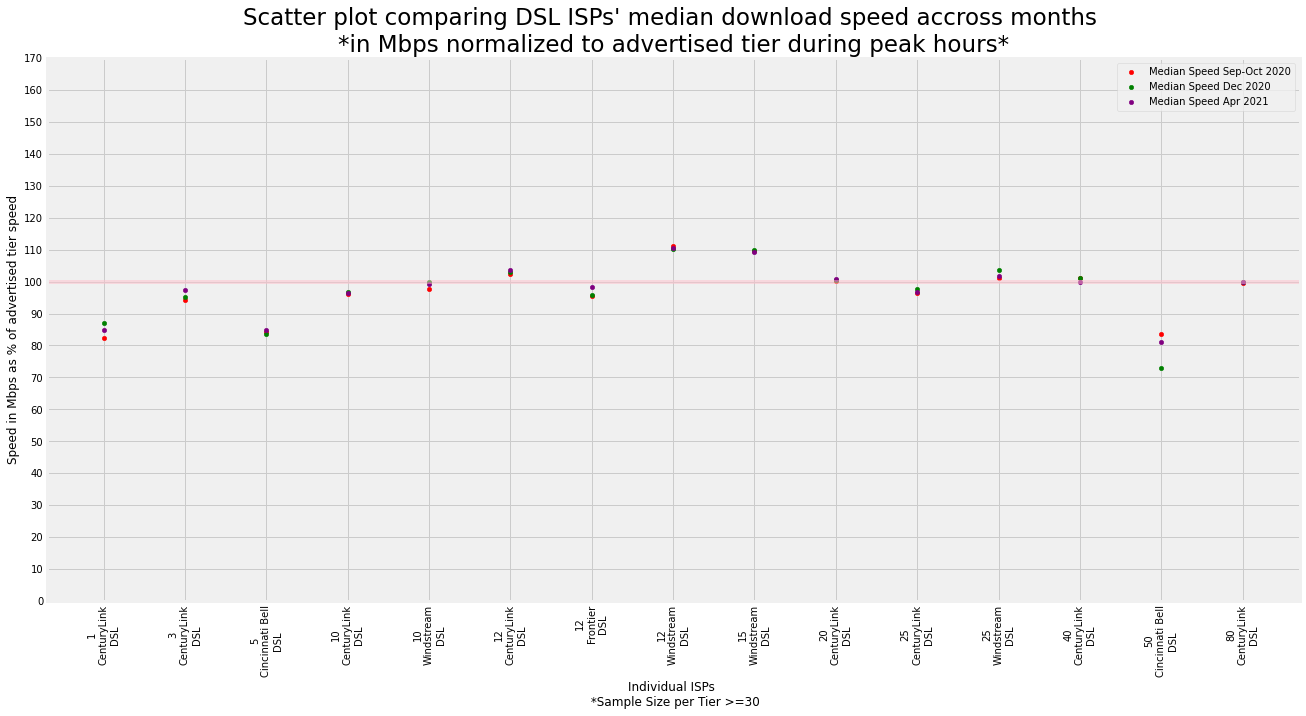

In [294]:
chartDF = finalDF.where(finalDF.tech =='DSL').dropna() 

plt.rcParams["figure.figsize"] = [20, 10]

ax1 = chartDF.plot(kind='scatter', x='ispTech_x', y='median_x', color='r', label = 'Median Speed Sep-Oct 2020')   
ax2 = chartDF.plot(kind='scatter', x='ispTech_y', y='median_y', color='g',label = 'Median Speed Dec 2020', ax=ax1)    
ax3 = chartDF.plot(kind='scatter', x='ispTech', y='median', color='purple', label = 'Median Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 180, 10))
plt.xticks(np.arange(0, len(chartDF), 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing DSL ISPs' median download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)


Text(0.5, 1.0, "Scatter plot comparing Cable ISPs' median download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

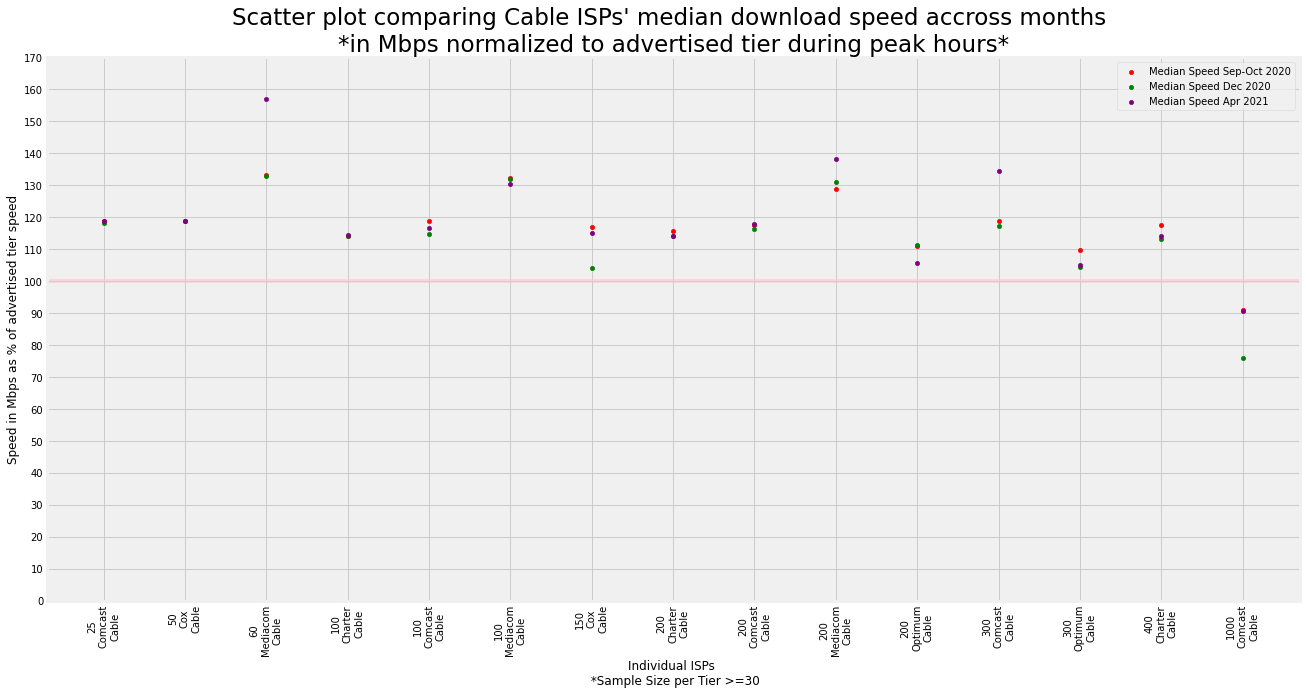

In [295]:
chartDF = finalDF.where(finalDF.tech =='Cable').dropna() 

plt.rcParams["figure.figsize"] = [20, 10]

ax1 = chartDF.plot(kind='scatter', x='ispTech_x', y='median_x', color='r', label = 'Median Speed Sep-Oct 2020')   
ax2 = chartDF.plot(kind='scatter', x='ispTech_y', y='median_y', color='g',label = 'Median Speed Dec 2020', ax=ax1)    
ax3 = chartDF.plot(kind='scatter', x='ispTech', y='median', color='purple', label = 'Median Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 180, 10))
plt.xticks(np.arange(0, len(chartDF), 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing Cable ISPs' median download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)


Text(0.5, 1.0, "Scatter plot comparing Fiber ISPs' median download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

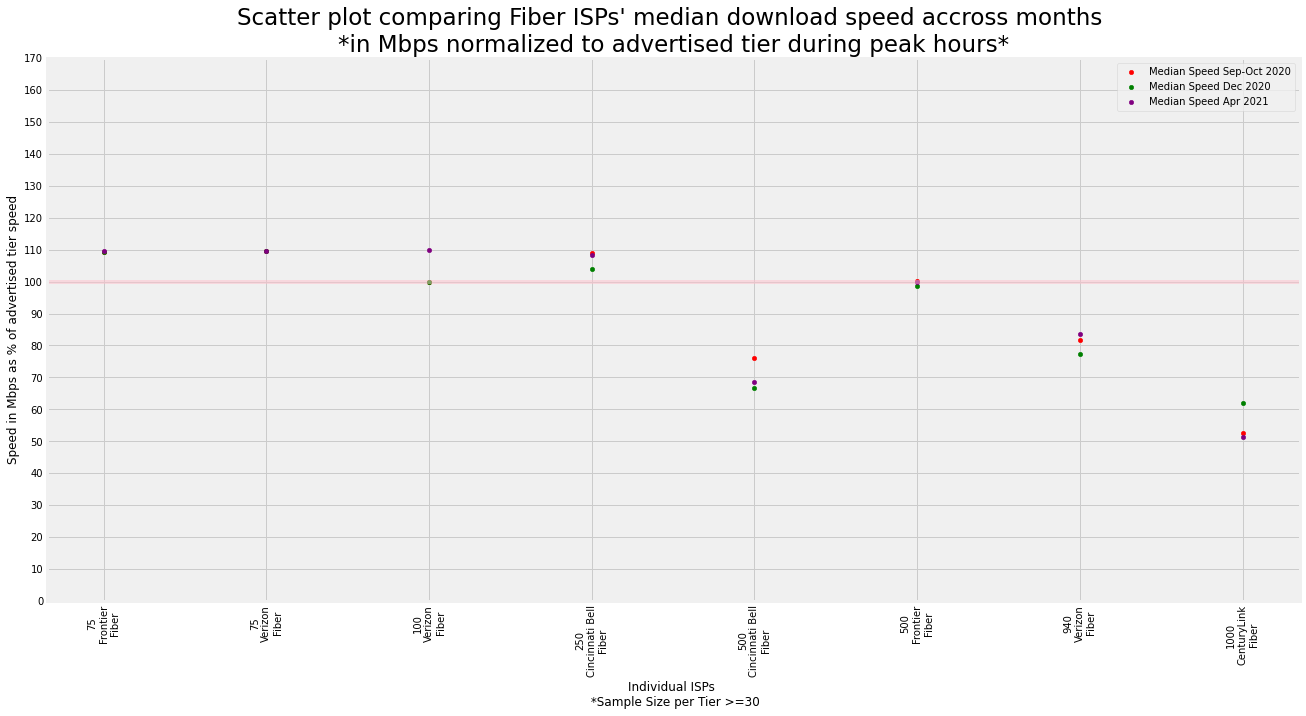

In [296]:
chartDF = finalDF.where(finalDF.tech =='Fiber').dropna() 

plt.rcParams["figure.figsize"] = [20, 10]

ax1 = chartDF.plot(kind='scatter', x='ispTech_x', y='median_x', color='r', label = 'Median Speed Sep-Oct 2020')   
ax2 = chartDF.plot(kind='scatter', x='ispTech_y', y='median_y', color='g',label = 'Median Speed Dec 2020', ax=ax1)    
ax3 = chartDF.plot(kind='scatter', x='ispTech', y='median', color='purple', label = 'Median Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 180, 10))
plt.xticks(np.arange(0, len(chartDF), 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing Fiber ISPs' median download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)


Text(0.5, 1.0, "Scatter plot comparing DSL ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

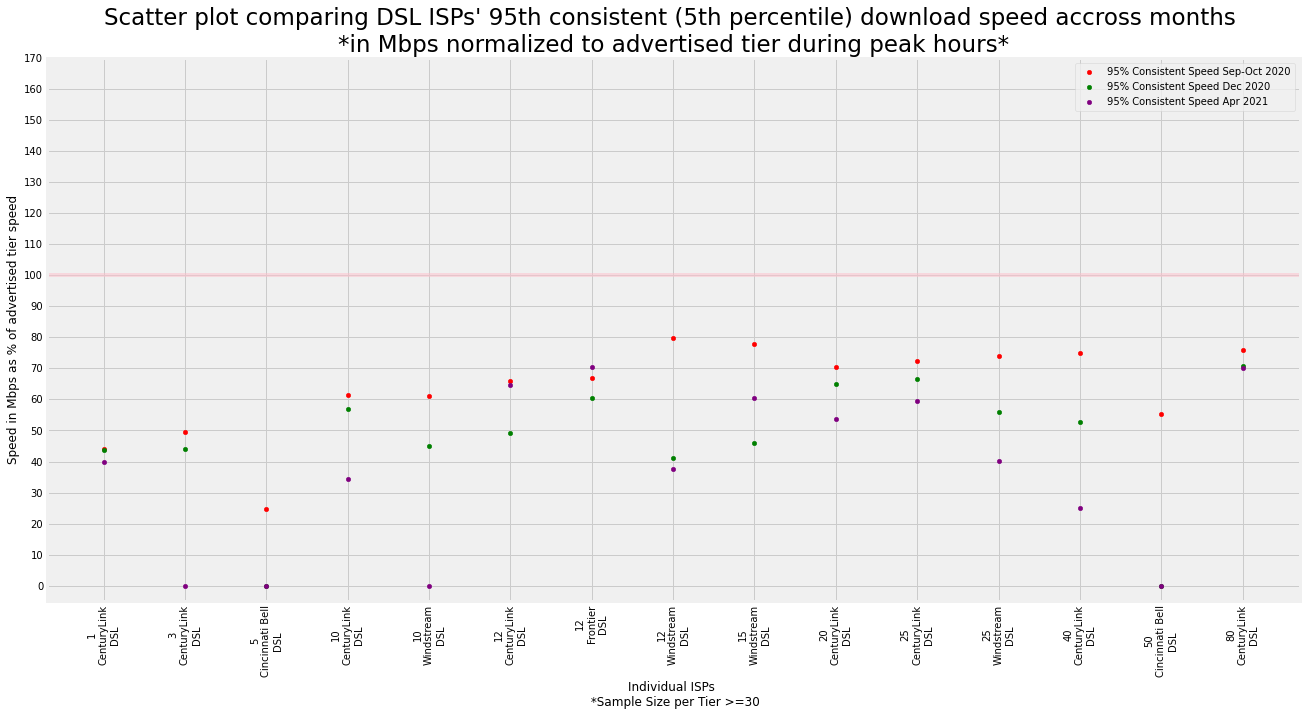

In [297]:
chartDF = finalDF.where(finalDF.tech =='DSL').dropna() 

plt.rcParams["figure.figsize"] = [20, 10]

ax1 = chartDF.plot(kind='scatter', x='ispTech_x', y='fivepct_x', color='r', label = '95% Consistent Speed Sep-Oct 2020')   
ax2 = chartDF.plot(kind='scatter', x='ispTech_y', y='fivepct_y', color='g',label = '95% Consistent Speed Dec 2020', ax=ax1)    
ax3 = chartDF.plot(kind='scatter', x='ispTech', y='fivepct', color='purple', label = '95% Consistent Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 180, 10))
plt.xticks(np.arange(0, len(chartDF), 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing DSL ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)


Text(0.5, 1.0, "Scatter plot comparing Cable ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

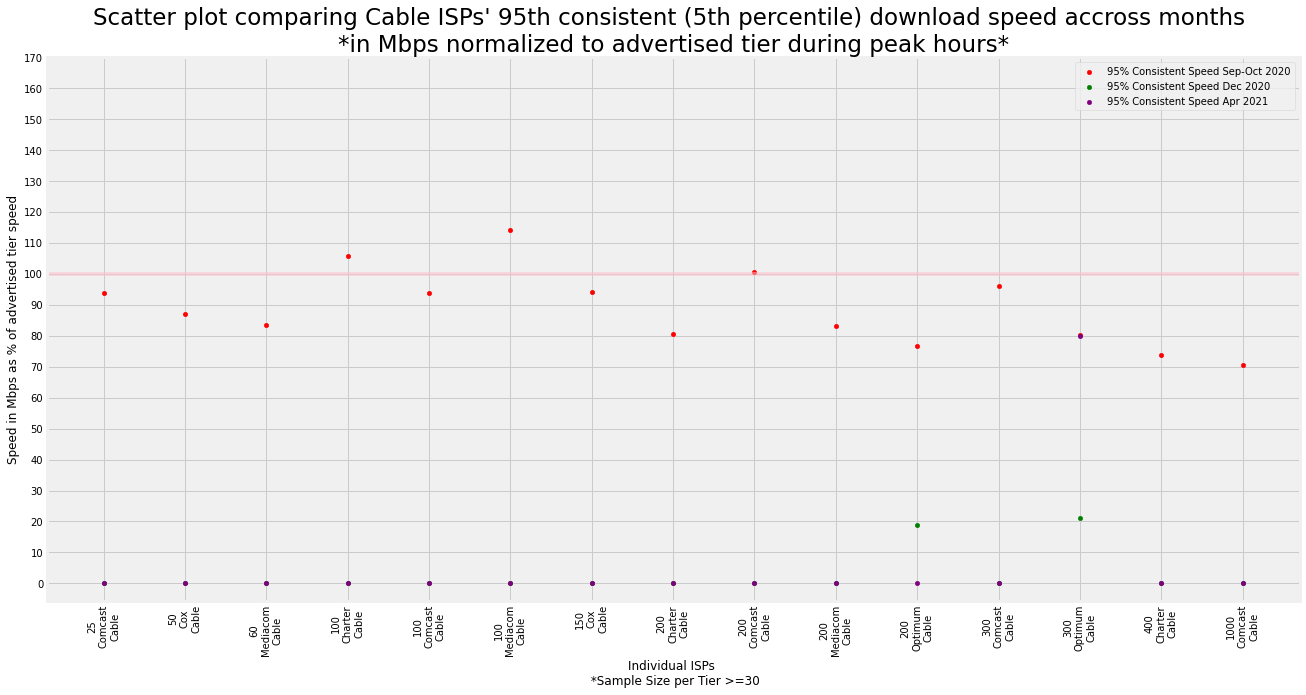

In [298]:
chartDF = finalDF.where(finalDF.tech =='Cable').dropna() 

plt.rcParams["figure.figsize"] = [20, 10]

ax1 = chartDF.plot(kind='scatter', x='ispTech_x', y='fivepct_x', color='r', label = '95% Consistent Speed Sep-Oct 2020')   
ax2 = chartDF.plot(kind='scatter', x='ispTech_y', y='fivepct_y', color='g',label = '95% Consistent Speed Dec 2020', ax=ax1)    
ax3 = chartDF.plot(kind='scatter', x='ispTech', y='fivepct', color='purple', label = '95% Consistent Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 180, 10))
plt.xticks(np.arange(0, len(chartDF), 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing Cable ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)


Text(0.5, 1.0, "Scatter plot comparing Fiber ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*")

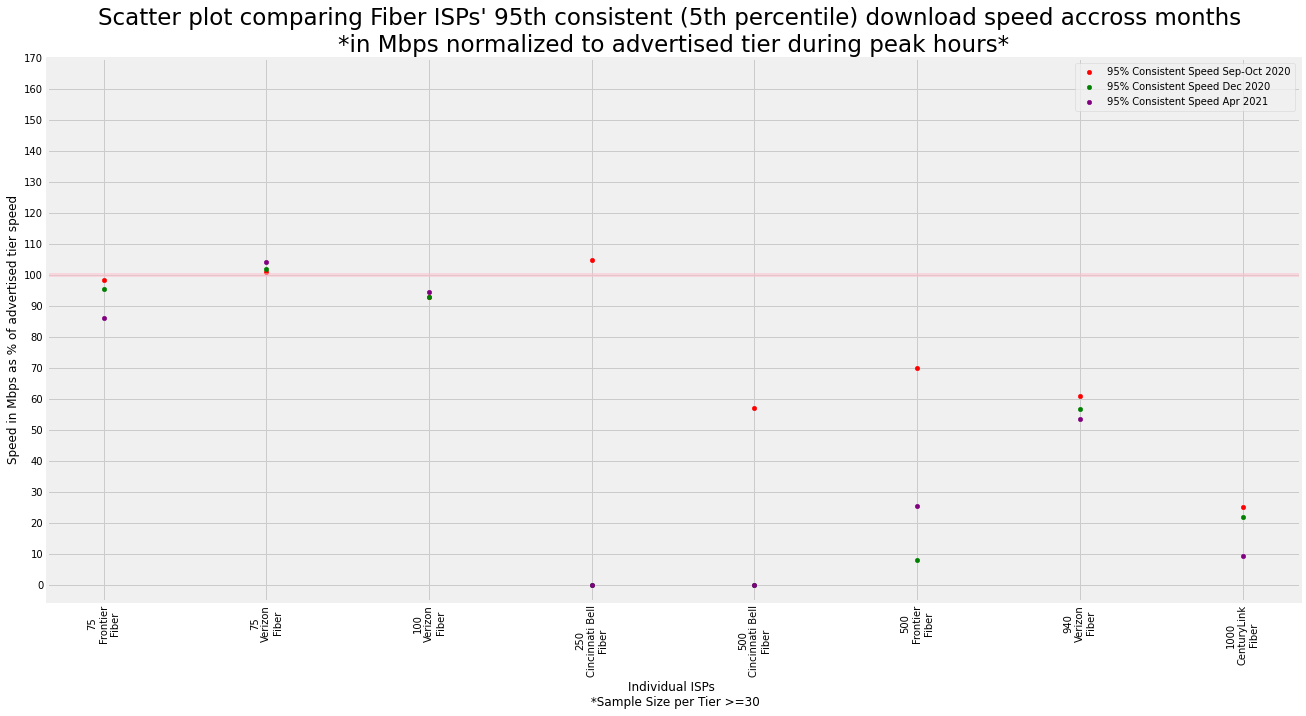

In [299]:
chartDF = finalDF.where(finalDF.tech =='Fiber').dropna() 

plt.rcParams["figure.figsize"] = [20, 10]

ax1 = chartDF.plot(kind='scatter', x='ispTech_x', y='fivepct_x', color='r', label = '95% Consistent Speed Sep-Oct 2020')   
ax2 = chartDF.plot(kind='scatter', x='ispTech_y', y='fivepct_y', color='g',label = '95% Consistent Speed Dec 2020', ax=ax1)    
ax3 = chartDF.plot(kind='scatter', x='ispTech', y='fivepct', color='purple', label = '95% Consistent Speed Apr 2021', ax=ax1)
ax1.axhline(y = 100, xmin = 0, xmax = 82, color = 'pink', linestyle = '-', alpha=0.5)

plt.yticks(np.arange(0, 180, 10))
plt.xticks(np.arange(0, len(chartDF), 1), rotation = 90)

ax1.set_xlabel('Individual ISPs \n *Sample Size per Tier >=30')
ax1.set_ylabel('Speed in Mbps as % of advertised tier speed')
ax1.set_title("Scatter plot comparing Fiber ISPs' 95th consistent (5th percentile) download speed accross months \n*in Mbps normalized to advertised tier during peak hours*", fontsize=23)
